# Assignment 2: Regression Modeling and Prediction 

## Exploratory Analysis and Plots 

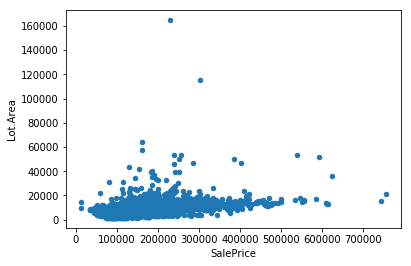

Sale.Condition
Abnorml    142501.932099
AdjLand    113300.000000
Alloca     162899.850000
Family     162082.857143
Normal     174771.834982
Partial    276710.954082
Name: SalePrice, dtype: float64


In [328]:
# Import the necesary libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  RFECV
import functools 
from util import *
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler


# Read in the training data 
df = pd.read_csv('Datasets/AmesHousingSetA.csv')

# Manually Encode the Central Air Feature 
df['Central.Air'] = df['Central.Air'].replace(to_replace='Y', value=1)
df['Central.Air'] = df['Central.Air'].replace(to_replace='N', value=0)

# Get Rid of Features that had a significant amount of null values 
del df['Alley']
del df['Pool.QC']
del df['Misc.Feature']
del df['Fireplace.Qu']
del df['Fence']

# PID is an ID column so it doed not make sense that it would have any effect on the SalePrice
# This can be seen in the scatter plot, there is no relationship between Sale Price and PID 
df.plot(kind='scatter', x='SalePrice', y= 'Lot.Area')
plt.show()
del df['PID']

# Grouping Sale.Condition and Sale Price to see which kind of Sale.Condition
# Has the higher average price 
print(df.groupby('Sale.Condition')['SalePrice'].mean())

# Call the cat_features function and make a list of all the Non-Numeric Features 
x = list(cat_features(df))

## Construct a Preprocessing Pipeline and One-Hot Encode the Data 

In [329]:
# Declare the Imputation to Fill in the NaN values with the median 
imp = preprocessing.Imputer(missing_values = 'NaN', strategy='mean', axis=0)

# Declare the Scaler to Standardize the columns with their z-scores 
scaler = preprocessing.StandardScaler()

# One Hot Encode the Categorical Columns 
df_dum = pd.get_dummies(df, columns = x)

# Segment the Independent and Dependent Variables 
base_data_x = df_dum.loc[:, df_dum.columns != 'SalePrice']
base_data_y = df_dum['SalePrice']

# Split into Training and Testing Set 
x_train, x_test, y_train, y_test = train_test_split(base_data_x, base_data_y, test_size=0.2, random_state = 4)

# Pass the Training Independent Variables through the Preprocessin Pipeline 
train_x_pp = imp.fit_transform(x_train)
train_x_pp = scaler.fit_transform(train_x_pp)


## Fit the Data on the Base model: A Simple Linear Regression Model 

In [330]:
# Declare the Base Linear Model and fit on the Training Data 
base_model = linear_model.LinearRegression()
base_model.fit(train_x_pp, y_train)

# Run the Testing data through the Preprocessing Pipeline
test_x_pp = imp.fit_transform(x_test)
test_x_pp = scaler.fit_transform(test_x_pp)

# Make Predictions on the testing data 
base_preds = base_model.predict(test_x_pp)

print('MSE, MAE, R^2, EVS: ' + str([mean_squared_error(y_test, base_preds),
                                    median_absolute_error(y_test, base_preds),
                                    r2_score(y_test, base_preds),
                                    explained_variance_score(y_test, base_preds)]))


MSE, MAE, R^2, EVS: [5.516768280330365e+32, 1907552652192646.2, -8.138226733864242e+22, -8.138226733864244e+22]


## Build the Best Model: Start with Feature Selection 

In [331]:
# Construct a Dictionary to store the F test P-Value for each coulmn 
feat_val = {}
selector_f = SelectPercentile(f_regression, percentile=25)
selector_f.fit(train_x_pp, y_train)
for name, score, pv in zip(list(df_dum), selector_f.scores_, selector_f.pvalues_):
    feat_val[name] = pv

/Users/ColinG/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/ColinG/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/ColinG/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/ColinG/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [332]:
# Take all the features that have a p-value of 0.04 or less 
FeatSel = ['SalePrice']
for i in feat_val:
    if feat_val[i] < 0.04:
        FeatSel.append(i)

# New Dataframe with the specially selected Features 
FeatSel_df = df_dum[FeatSel]

# Segment the Independent and Dependent Variables 
data_x = FeatSel_df.loc[:, FeatSel_df.columns != 'SalePrice']
data_y = FeatSel_df['SalePrice']

# Split into Training and Testing Set 
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state = 4)

# Pass the Training Independent Variables through the Preprocessing Pipeline 
train_x_pp = imp.fit_transform(x_train)
train_x_pp = scaler.fit_transform(train_x_pp)


In [333]:
test_x_pp = imp.fit_transform(x_test)
test_x_pp = scaler.fit_transform(test_x_pp)

## Test a Couple Different Models to see what fits best 

In [334]:
# Lasso Regression Model 
Lasso_test = linear_model.Lasso(alpha=0.5, normalize = True)
Lasso_test.fit(train_x_pp, y_train)
Lasso_preds = Lasso_test.predict(test_x_pp)

# Ridge Regression Model 
Ridge_test = linear_model.Ridge(alpha = 0.5)
Ridge_test.fit(train_x_pp, y_train)
Ridge_preds = Ridge_test.predict(test_x_pp)

# Quadratic Regression Model 
Quad_test = PolynomialFeatures(degree=2)
Quad_Data_x_train = Quad_test.fit_transform(train_x_pp)
Quad_Data_x_test = Quad_test.fit_transform(test_x_pp)
Quad_mod = linear_model.LinearRegression()
Quad_mod.fit(Quad_Data_x_train, y_train)
quad_preds = Quad_mod.predict(Quad_Data_x_test)

print("The R^2 for the Lasso Model is: " + str(r2_score(y_test, Lasso_preds)))
print('The R^2 for the Ridge Model is: ' + str(r2_score(y_test, Ridge_preds)))
print("The R^2 for the Quadratic Model is: " + str(r2_score(y_test, quad_preds)))

/Users/ColinG/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The R^2 for the Lasso Model is: 0.9018243236257353
The R^2 for the Ridge Model is: 0.901331714541974
The R^2 for the Quadratic Model is: -117198752739959.61


## Test Different Alpha Levels for the Lasso Model 

In [335]:
# List of different possible alpha levels for the Ridge Regression 
alphas = [0.0, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0]

# Loop through the alphas and build  Lasso Model with each and Check the R^2
for alpha in alphas: 
    model = linear_model.Lasso(alpha = alpha, normalize=True)
    model.fit(train_x_pp, y_train)
    preds = model.predict(test_x_pp)
    print('R^2 (Lasso model with alpha =' + str(alpha) + '):' + str(r2_score(y_test, preds)))


/Users/ColinG/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/ColinG/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/ColinG/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R^2 (Lasso model with alpha =0.0):0.9008271357206838
R^2 (Lasso model with alpha =0.001):0.9008298406250516
R^2 (Lasso model with alpha =0.01):0.9008515372781289
R^2 (Lasso model with alpha =0.1):0.9011066267259815
R^2 (Lasso model with alpha =0.25):0.9014188184317952
R^2 (Lasso model with alpha =0.5):0.9018243236257353
R^2 (Lasso model with alpha =1.0):0.902349224190156
R^2 (Lasso model with alpha =2.5):0.9032311053170106
R^2 (Lasso model with alpha =5.0):0.9029248838948771


## Use the specially selected features and the best alpha level to build that Best Model 

In [336]:
# Based on the tested alpha levels we can see that the R^2 begins to drop off at around 2.5 

# Build the Best Lasso Model using alpha of 2.5 
best_model = linear_model.Lasso(alpha = 2.5, normalize=True)

# Fit it with the preprocessed testing data 
best_model.fit(train_x_pp,  y_train)

# Make predictions using the preprocesed testing data 
best_preds = best_model.predict(test_x_pp)

# R^2 value for the Best model on the Testing set 
print("R^2 for Best model: " + str(r2_score(y_test, best_preds)))


R^2 for Best model: 0.9032311053170106


## Read in the B Dataset and perform the Necesary transformations 

In [337]:
# Read in the data from the B Set 
df_b = pd.read_csv('Datasets/AmesHousingSetB.csv')
df_b['Central.Air'] = df_b['Central.Air'].replace(to_replace='Y', value=1)
df_b['Central.Air'] = df_b['Central.Air'].replace(to_replace='N', value=0)

# Get Rid of Features that had a significant amount of null values or were insignificant 
del df_b['Alley']
del df_b['Pool.QC']
del df_b['Misc.Feature']
del df_b['Fireplace.Qu']
del df_b['Fence']
del df_b['PID']

# List of the Categorical Features 
x_b = list(cat_features(df_b))

## Test the Base and Best Models with the Transformed Data from Dataset B 

In [338]:
# One Hot encode the B Dataset 
df_dum_b = pd.get_dummies(df_b, columns = x_b)

# Loop Through and check what columns are in B but not in A, and then delete them 
for i in df_dum_b.columns:
    if i not in df_dum.columns:
        del df_dum_b[i]
        
# Loop through and check what columns are in A but not in B, and then add them 
for i in df_dum.columns:
    if i not in df_dum_b.columns:
        df_dum_b[i] = pd.Series(np.zeros(len(df_dum_b)))

# Segment the data 
dataB_x = df_dum_b.loc[:, df_dum_b.columns != 'SalePrice']
dataB_y = df_dum_b['SalePrice']


# Pass the Independent Variables through the Preprocessin Pipeline 
dataB_x_pp = imp.fit_transform(dataB_x)
dataB_x_pp = scaler.fit_transform(dataB_x_pp)

# Make the predictions on the data 
B_base_preds = base_model.predict(dataB_x_pp)

# Compute the R^2 of the model 
print("R^2 for the Base model on the B Dataset is: " + str(r2_score(dataB_y, B_base_preds)))

R^2 for the Base model on the B Dataset is: -7.212398132165294e+23


In [339]:
# Segment the Feature Selected Data for Best Model 
dataB_best = df_dum_b[FeatSel]

# Seperate into X and Y 
dataB_x_best = dataB_best.loc[:, dataB_best.columns != 'SalePrice']
dataB_y_best = dataB_best['SalePrice']

# Send the data through the Preproccesing Pipeline 
dataB_x_best_pp = imp.fit_transform(dataB_x_best)
dataB_x_best_pp = scaler.fit_transform(dataB_x_best_pp)

# Make Predictions on the B Dataset 
best_preds_B = best_model.predict(dataB_x_best_pp)

# Print the R^2 for the data 
print("R^2 for the Best Model on the B Dataset is: " + str(r2_score(best_preds_B, dataB_y_best)))

R^2 for the Best Model on the B Dataset is: 0.9130786140451412


# I. Data Preparation Questions 

## 1) 

## To transform the data, I one hot encoded all the categorical columns. For the Central.Air column, I manually changed the values from "Y" to 1, and from "N" to 0. This one-hot encoding made the 81 column data frame a 300 column dataframe.  

# II. Exploratory Analysis Questions 

## 1) 

## When looking at the data, there were a few columns that had a significant amount of NaN values. For examples    only had 9 non-NaN values. For this column and the 4 other columns similar to it I removed them, as they would not be good predictors due to having barely any data. 

## Also, I removed the PID column because it was simply an ID column. It is a unqiue value for each of the rows that has no bearing on the SalePrice. I checked this with a scatter plot on sale price and it as expected showed no relationship. 

## 2) 

## I expected fr Lot.Area to have a positive effect on Sale Price. I was surprised when looking at the scatter plot and seeing what looked like not correlation at all. 

# III. Model Building Questions 

## 1) 

## To arrive at my most accurate model, I used  Lasso Regression Model. I had learned in my DATA 419 class that Lasso was on average the most accurate when compare to basic linear and ridge regression so I decided to test with Lasso first. To confirm this, built 3 models to test, a Lasso Model, a Ridge model, and a Quadratic model. 

## After fitting and predicting with each of these models, the R^2 for the Lasso and Ridge regression models were very close, with the Lasso being higher by about a percent. The Quadratic was a very poor fit so that was ignored. 

## Finally, I featured selcted by running an F-Test on every explanatory column and then only including the columns that had a p-value of 0.04 or less. This allowed me to get rid of columns not as important and keep the ones with real signifigance in the model. 

## 2) 

## The Primary error metrics used to evaluate the Base and Best model was the R^2 value. The R^2 for the base Linear model was incredibly small, at about , meanwhile with the Best model the R^2 sat right around 90%. 

# IV. Predicting and Validating Questions 

## 1) 

## My Best Model once again greatly outscored my baseline model on the B dataset. The Base model had a -7.212 x 10^23 R^2. The Best model had a very accuracte R^2 of 0.913. 

## 2) 

## The Best Model is a very good model, however it does require a decent amount of transformation of the data, and ignores certain columns that originally had too many null values. Therefore new with less null values could effect the accuracy of the model. 

## Another issue with the model is probably with misunderstanding the column names. It was difficult to understand what some of the columns actually represented, so therefore some untrue assumptions could have been made that would influence feature selection. 